In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pyarrow as pa
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import sys
print(sys.executable)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/niteesh/opt/anaconda3/envs/tradingEnv/bin/python


In [4]:
from utils import *

from feature_factory import add_feature_col_inplace, get_feature_col
from backtester import BackTester
# from strategy import basic_lin_regr_model1, monetization_strategy1

In [16]:
btc_df = pd.read_parquet("data/BTCUSDT.pq")
valid_coins = []
for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        x_df = pd.read_parquet(os.path.join("data/", filename))

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            continue
        
        valid_coins.append(filename[:-3])

print(valid_coins)

CHRUSDT.pq
SLPUSDT.pq
GFTUSDT.pq
ALPHAUSDT.pq
MYROUSDT.pq
RONUSDT.pq
ZKJUSDT.pq
SAFEUSDT.pq
ETCPERP.pq
USDEUSDT.pq
ORBSUSDT.pq
XVSUSDT.pq
BTC-11OCT24.pq
MASKUSDT.pq
ZKFUSDT.pq
ENAUSDT.pq
SOL-25OCT24.pq
COSUSDT.pq
TNSRUSDT.pq
SNTUSDT.pq
1000000PEIPEIUSDT.pq
POLPERP.pq
BLASTUSDT.pq
XVGUSDT.pq
SNXUSDT.pq
PENGUSDT.pq
FTMUSDT.pq
1000MUMUUSDT.pq
BTC-18OCT24.pq
VANRYUSDT.pq
XMRUSDT.pq
NEARUSDT.pq
BANDUSDT.pq
ARPAUSDT.pq
ASTRUSDT.pq
WIFUSDT.pq
SILLYUSDT.pq
AEVOUSDT.pq
AKROUSDT.pq
CHESSUSDT.pq
FLRUSDT.pq
DASHUSDT.pq
ALEOUSDT.pq
AIOZUSDT.pq
FIOUSDT.pq
CYBERUSDT.pq
ORDIPERP.pq
AXLUSDT.pq
OMGUSDT.pq
OPPERP.pq
SSVUSDT.pq
BOMEUSDT.pq
VTHOUSDT.pq
ZROUSDT.pq
BBUSDT.pq
COREUSDT.pq
POPCATUSDT.pq
ALTUSDT.pq
CELOUSDT.pq
L3USDT.pq
NTRNUSDT.pq
FDUSDUSDT.pq
MERLUSDT.pq
DEXEUSDT.pq
ETH-28MAR25.pq
STRKUSDT.pq
LTCUSDT.pq
CVXUSDT.pq
KASUSDT.pq
C98USDT.pq
PHBUSDT.pq
VELOUSDT.pq
LTOUSDT.pq
FLUXUSDT.pq
AMBUSDT.pq
ARUSDT.pq
ETHWUSDT.pq
APTUSDT.pq
CKBUSDT.pq
MNTUSDT.pq
ETHFIUSDT.pq
CAKEUSDT.pq
ATOMUSDT.pq
IDUSDT.pq
I

In [19]:
def basic_lin_regr_model1(df, y_df, mn_df, feats, symbols):

    # feats = {'SILLYUSDT': ['Momentum__SILLYUSDT_1H', 'ZScore__SILLYUSDT_1H_5H',
    #    'PriceChangeRate__SILLYUSDT_1H'], 
    #    'VRAUSDT': ['ZScore__VRAUSDT_1H_5H',
    #    'ZScore__VRAUSDT_1H_10H', 'VolumeMA__VRAUSDT_1W']}


    strategy_df = df.dropna().copy()

    for symbol in symbols:

        y_col = f'FutureLogReturn__{symbol}_1H_MN'

        datasets = get_datasets(df[feats[symbol]], mn_df, y_col)

        X_train, X_test, y_train, y_test = datasets
        test_start_date = X_test.index[0]

        model = get_LR_model(datasets)

        strategy_df.loc[:, f'{symbol}_signal'] = pd.Series(model.predict(strategy_df[feats[symbol]]), index=strategy_df.index)

        train_signal_std = strategy_df[strategy_df.index < test_start_date][f'{symbol}_signal'].std()

        strategy_df.loc[:, f'{symbol}_signal'] = strategy_df[f'{symbol}_signal'] / train_signal_std

        # strategy_df.loc[:, f'{symbol}_signal'] = mn_df[y_col]

    return strategy_df

def get_mapping_func(a1, a2, a3, a4):
    def get_ideal_pos(signal):
        if signal < a1:
            return -1.0
        elif signal < a2:
            return (signal - a2) / (a2 - a1)
        elif signal < a3:
            return 0.0
        elif signal < a4:
            return (signal - a3) / (a4 - a3)
        else:
            return 1.0
    return get_ideal_pos

def monetization_strategy1(strategy_df, symbols):

    backtest_df = pd.DataFrame()
    
    # RSRUSDT_mapping_func = get_mapping_func(-1.728, -0.815, 0.236, 1.062)
    # SILLYUSDT_mapping_func = get_mapping_func(-0.700, -0.170, 0.396, 1.252)
    for symbol in symbols:
        currMappingFunc = np.sign
        backtest_df[f'{symbol}_price'] = strategy_df[f'OpenPrice__{symbol}']
        backtest_df[f'{symbol}_pos'] = strategy_df[f'{symbol}_signal'].map(currMappingFunc)
        holding_minutes = 10
        mask = (backtest_df.reset_index().index.to_series().index % holding_minutes == 0)
        backtest_df[f'{symbol}_pos'] = backtest_df[f'{symbol}_pos'].where(mask, pd.NA).ffill()
        
    backtest_df['BTCUSDT_price'] = strategy_df['OpenPrice__BTCUSDT']

    # trade every X minutes
    # holding_minutes = 10
    # mask = (backtest_df.reset_index().index.to_series().index % holding_minutes == 0)
    # backtest_df['VRAUSDT_pos'] = backtest_df['VRAUSDT_pos'].where(mask, pd.NA).ffill()
    # backtest_df['SILLYUSDT_pos'] = backtest_df['SILLYUSDT_pos'].where(mask, pd.NA).ffill()

    return backtest_df


In [43]:
random_coins = random.sample(valid_coins, 40)
# random_coins[int(len(random_coins)/2) + 1:]
subset1 = random_coins[:int(len(random_coins)/2)]
subset2 = random_coins[int(len(random_coins)/2) + 1:]
# subset1 = ['COTIUSDT']
# subset2 = ['REEFUSDT']
DATA_PATH = "data"

maxPNL = -1
maxSymbs = []

for symbol1 in subset1:
    for symbol2 in subset2:
        trading_symbols = [
            symbol1,
            symbol2
        ]
        symbols = trading_symbols + ['BTCUSDT']

        df = get_combined_data(symbols, DATA_PATH)

        # Feature Engineering
        # add_return_cols_inplace(df, 'open', [5, 60, 1440])


        df.rename(columns={f'BTCUSDT_open': f'OpenPrice__BTCUSDT'}, inplace=True)

        df.rename(columns={f'{symbol1}_open': f'OpenPrice__{symbol1}'}, inplace=True)
        df.rename(columns={f'{symbol1}_volume': f'Volume__{symbol1}'}, inplace=True)
        df.rename(columns={f'{symbol2}_open': f'OpenPrice__{symbol2}'}, inplace=True)
        df.rename(columns={f'{symbol2}_volume': f'Volume__{symbol2}'}, inplace=True)


        lin_regr_features = [
            f'Momentum__{symbol1}_1H',
            f'ZScore__{symbol1}_1H_5H',
            f'VolumeMA__{symbol1}_1W',
            f'Momentum__{symbol2}_1H',
            f'ZScore__{symbol2}_1H_5H',
            f'VolumeMA__{symbol2}_1W',

            f'RollingBeta__{symbol1}_BTCUSDT_10080',
            f'RollingBeta__{symbol2}_BTCUSDT_10080',
        ]

        for lin_regr_feature in lin_regr_features:
            # print(lin_regr_feature)
            add_feature_col_inplace(df, lin_regr_feature)

        FEATURE = 'FutureLogReturn'

        y_df = pd.DataFrame()
        for symbol in symbols:
            feat = f'{FEATURE}__{symbol}_1H'
            y_df[feat] = get_feature_col(df, feat)

        mn_df = pd.DataFrame()
        for symbol in trading_symbols:
            mn_df[f'FutureLogReturn__{symbol}_1H_MN'] = y_df[f'{FEATURE}__{symbol}_1H'] - df[f'RollingBeta__{symbol}_BTCUSDT_10080'] * y_df[f'{FEATURE}__BTCUSDT_1H']
            
            def mappp(x):
                if x < -0.002:
                    return -x
                elif x < 0.002:
                    return 0.0
                else:
                    return x

            
            mn_df[f'FutureLogReturn__{symbol}_1H_MN'] = mn_df[f'FutureLogReturn__{symbol}_1H_MN'].map(mappp)
        
        feats = {symbol1: [f'Momentum__{symbol1}_1H', f'ZScore__{symbol1}_1H_5H',
       f'VolumeMA__{symbol1}_1W'], 
       symbol2: [f'Momentum__{symbol2}_1H', f'ZScore__{symbol2}_1H_5H',
       f'VolumeMA__{symbol2}_1W']}
        from backtester import BackTester
        strategy_df = basic_lin_regr_model1(df, y_df, mn_df, feats, trading_symbols)
        backtest_df = monetization_strategy1(strategy_df, trading_symbols)
        backTester = BackTester(backtest_df)
        endPNL = backTester.get_result_df()['trade_cost_pnl'].iloc[-30]
        print(endPNL)
        if endPNL > maxPNL:
            maxPNL = endPNL
            maxSymbs = trading_symbols.copy()
            maxBacktester = backTester
        # print(maxSymbs)
        # backTester.plot_individual_pnl()

# print(df[lin_regr_features].columns)
# print(y_df.columns)
# print(mn_df.columns)
# print(mn_df.columns)

MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0005
R^2 score: -0.1646
train MSE: 0.0004
train R^2 score: 0.0320
0.2049979900437332
MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0001
R^2 score: -0.0544
train MSE: 0.0001
train R^2 score: 0.0117
-0.04481906937361859
MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0009
R^2 score: -0.1516
train MSE: 0.0002
train R^2 score: 0.0218
0.32784360358518005
MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0007
R^2 score: -0.0055
train MSE: 0.0001
train R^2 score: 0.0123
0.1558229899819627
MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0000
R^2 score: -0.0151
train MSE: 0.0000
train R^2 score: 0.0136
-0.06977362955826721
MSE: 0.0000
R^2 score: -0.1864
train MSE: 0.0001
train R^2 score: 0.0718
MSE: 0.0006
R^2 score: -0.0815
train MSE: 0.0012
train R^2 score: 0.0800
0.2073377670000493
MSE: 

['COTIUSDT', 'REEFUSDT'] 1.6602220388177933


<Figure size 10000x8000 with 0 Axes>

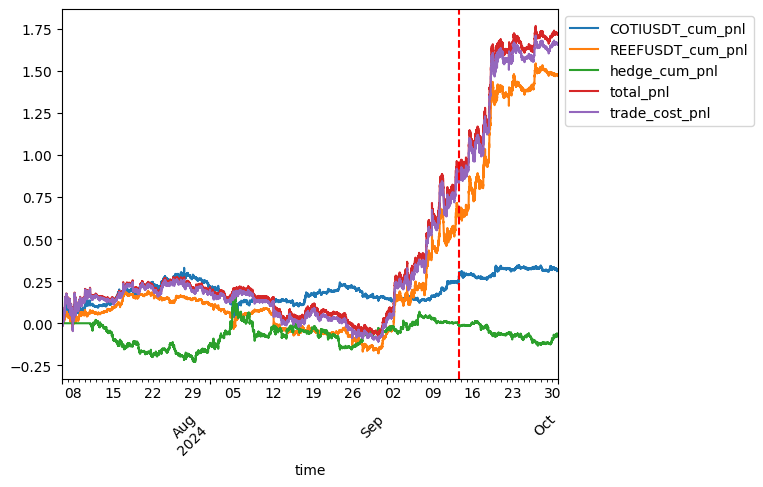

In [42]:
print(maxSymbs, maxPNL)
maxBacktester.plot_individual_pnl()